# Non congested latency

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def compare_latency_plots_with_epsilon_combined_legend(baseline, madrl, q_learning_path, epsilon_path, window_size=20, marker_size=50):
    sns.set(font_scale=1.5)

    # Load datasets
    df1_raw_base = pd.read_csv(baseline)
    df2_raw_madrl = pd.read_csv(madrl)
    q_learning_df = pd.read_csv(q_learning_path)
    epsilon_df = pd.read_csv(epsilon_path)

    # Convert to milliseconds
    for df in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df['Latency'] *= 1000
        df['Creation Time'] *= 1000
    epsilon_df['time'] *= 1000
    

    # Process latency data
    for df_raw in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
        df_raw.sort_values(by=['Source', 'Destination', 'Block Index'], inplace=True)
        df_raw['Path'] = df_raw['Source'].astype(str) + ' -> ' + df_raw['Destination'].astype(str)
        df_raw['Latency_Rolling_Avg'] = df_raw.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Create subplot for each path
    unique_paths = df1_raw_base['Path'].unique()
    for path in unique_paths:
        plt.figure(figsize=(10, 5))

        # Filter data for the current path
        df1_path_base = df1_raw_base[df1_raw_base['Path'] == path]
        df2_path_madrl = df2_raw_madrl[df2_raw_madrl['Path'] == path]
        q_learning_path_df = q_learning_df[q_learning_df['Path'] == path]

        # Create twin axis for epsilon
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # Plot latency trends for all three policies
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df1_path_base, label='Shortest path', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df2_path_madrl, label='MA-DRL', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=q_learning_path_df, label='Q-Learning', markersize=marker_size, ax=ax1)

        # Plot epsilon trend
        sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', label='Exploration rate', ax=ax2)

        # Find and annotate minimum latency values for each dataset
        min_values = [
            (df1_path_base, 'blue', (-50, 50)),
            (df2_path_madrl, 'orange', (-50, 90)),
            (q_learning_path_df, 'green', (-80, 60))
        ]
        for df, color, offset in min_values:
            min_latency = df['Latency_Rolling_Avg'].min()
            min_pos = df['Creation Time'][df['Latency_Rolling_Avg'].idxmin()]
            ax1.annotate(f'{min_latency:.0f} ms', xy=(min_pos, min_latency), xytext=offset, textcoords='offset points', arrowprops=dict(arrowstyle='->', color=color))

            # Remove individual legends if they exist
            if ax1.get_legend() is not None:
                ax1.get_legend().remove()
            if ax2.get_legend() is not None:
                ax2.get_legend().remove()


            # Get handles and labels
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()

            # Reorder the items in the legend
            # 'Shortest path' is the first item in labels1, 'MA-DRL' is the second, 'Q-Learning' is the third, and 'Exploration rate' is the first item in labels2
            handles_reordered = [handles1[1], handles1[2], handles1[0], handles2[0]]
            labels_reordered = [labels1[1], labels1[2], labels1[0], labels2[0]]

            # Create a new legend with the reordered handles and labels
            ax1.legend(handles_reordered, labels_reordered, loc='upper right', bbox_to_anchor=(1, 0.98), frameon=True, facecolor='white', framealpha=1)

        # Set plot titles and labels
        path = path.replace("->", "to")
        path = path.replace('Northwest Territories, ', '')
        plt.title(f'Average latency for {path}')
        ax1.set_xlabel('Packet creation time [ms]')
        ax1.set_ylabel('Average E2E latency [ms]')
        ax2.set_ylabel('Exploration rate (%)')

        plt.tight_layout()
        plt.savefig(f'{path}.png', dpi=300)
        plt.show()
        plt.close()

    sns.set(font_scale=1.0)

compare_latency_plots_with_epsilon_combined_legend('allLatencies_2_gateways_DataRate_Shifted.csv', 'allLatencies_2_gateways_shifted_DRL.csv', 'Q-Learning_Kepler.csv', 'epsilons_2_gateways_Kepler.csv', window_size=20, marker_size=5)
# compare_latency_plots_with_epsilon_combined_legend('DataRate_Kepler.csv', 'AGP-LA_DRL_Kepler.csv', 'Q-Learning_Kepler.csv', 'epsilons_2_gateways_Kepler.csv', window_size=20, marker_size=5)


SyntaxError: invalid syntax (3250753125.py, line 82)

# 8 GTs no congestio learning

KeyboardInterrupt: 

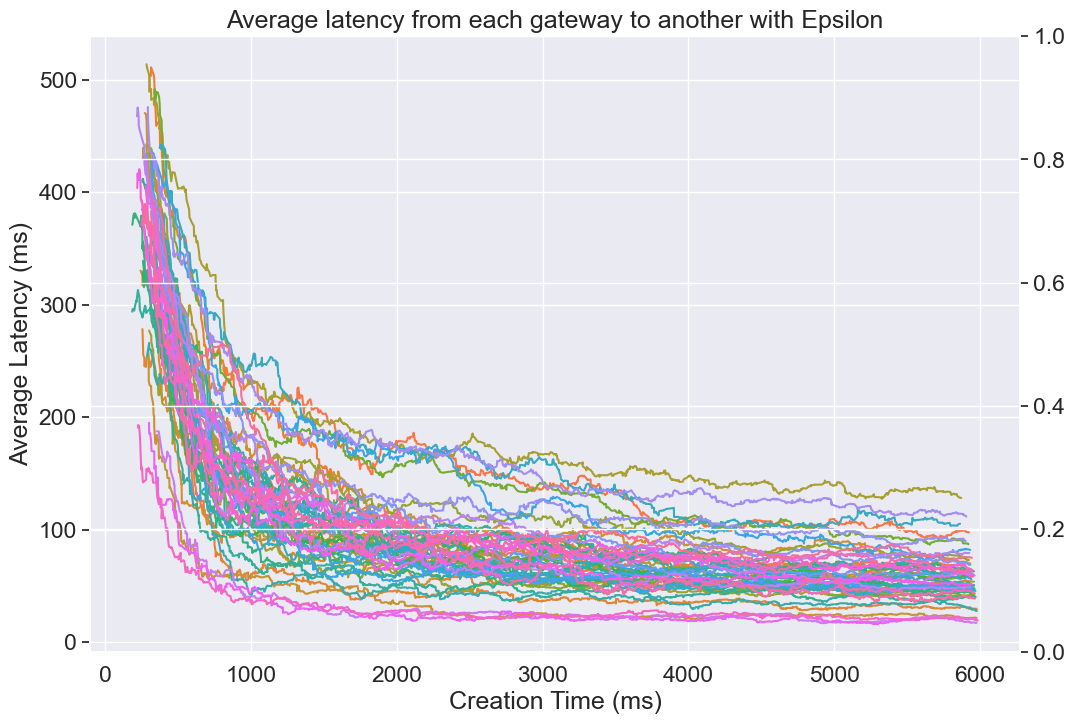

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plotSaveLatenciesByCreationTime(outputPath, allLatenciesDF, epsDF, window_size, annotate_min=False):
    # Assume allLatenciesDF and epsDF are already DataFrames
    # Set visual settings
    sns.set(font_scale=1.5)
    
    # Convert time values to milliseconds
    allLatenciesDF['Creation Time'] *= 1000
    allLatenciesDF['Latency'] *= 1000
    epsDF['time'] *= 1000  # Assuming 'time' is the column in epsDF that matches 'Creation Time'
    
    # Calculate rolling average latency
    allLatenciesDF['Path'] = allLatenciesDF['Source'].astype(str) + ' -> ' + allLatenciesDF['Destination'].astype(str)
    allLatenciesDF.sort_values(by='Creation Time', inplace=True)
    allLatenciesDF['Latency_Rolling_Avg'] = allLatenciesDF.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Plot latency
    plt.figure(figsize=(12, 8))
    ax1 = sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', hue='Path', data=allLatenciesDF)
    plt.title('Average latency from each gateway to another with Epsilon')
    plt.xlabel('Creation Time (ms)')
    plt.ylabel('Average Latency (ms)')
    plt.legend().set_visible(False)

    # Plot epsilon on a twin y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x='time', y='epsilon', data=epsDF, color='purple', label='Epsilon', ax=ax2)
    ax2.set_ylabel('Epsilon')
    ax2.set_ylim(bottom=0)  # Start the epsilon axis at 0


    # Annotate minimum latencies
    if annotate_min:
        for path in allLatenciesDF['Path'].unique():
            path_df = allLatenciesDF[allLatenciesDF['Path'] == path]
            min_latency_row = path_df.loc[path_df['Latency_Rolling_Avg'].idxmin()]
            ax1.text(min_latency_row['Creation Time'], min_latency_row['Latency_Rolling_Avg'], 
                     f"{min_latency_row['Latency_Rolling_Avg']:0.0f} ms", 
                     color='black', ha='right')

    # Show & Save plot
    plt.show()
    plt.savefig(outputPath + 'learning_8_gateways.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
# Load the latency and epsilon data into DataFrames
allLatenciesDF = pd.read_csv('./allLatencies_8_gateways_learning.csv')
epsDF = pd.read_csv('./epsilons_8_gateways.csv')  # You'll need to replace './epsilon_data.csv' with your actual epsilon data file path

# Call the function with both DataFrames and annotate_min set to True
plotSaveLatenciesByCreationTime('./', allLatenciesDF, epsDF, 50, annotate_min=False)


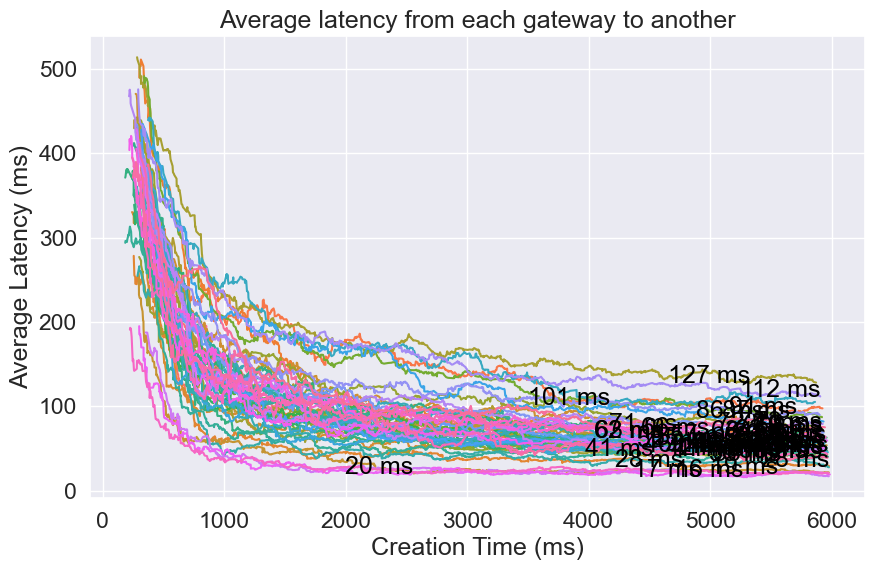

In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plotSaveLatenciesByCreationTime(outputPath, allLatenciesDF, window_size, annotate_min=False):
    # Assume allLatenciesDF is already a DataFrame
    # Set visual settings
    sns.set(font_scale=1.5)
    
    # Convert time values to milliseconds
    allLatenciesDF['Creation Time'] *= 1000
    allLatenciesDF['Latency'] *= 1000
    
    # Calculate rolling average latency
    allLatenciesDF['Path'] = allLatenciesDF['Source'].astype(str) + ' -> ' + allLatenciesDF['Destination'].astype(str)
    allLatenciesDF.sort_values(by='Creation Time', inplace=True)
    allLatenciesDF['Latency_Rolling_Avg'] = allLatenciesDF.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', hue='Path', data=allLatenciesDF)
    plt.title('Average latency from each gateway to another')
    plt.xlabel('Creation Time (ms)')
    plt.ylabel('Average Latency (ms)')
    plt.legend().set_visible(False)

    # Annotate minimum latencies
    if annotate_min:
        for path in allLatenciesDF['Path'].unique():
            path_df = allLatenciesDF[allLatenciesDF['Path'] == path]
            min_latency_row = path_df.loc[path_df['Latency_Rolling_Avg'].idxmin()]
            plt.text(min_latency_row['Creation Time'], min_latency_row['Latency_Rolling_Avg'], 
                     f"{min_latency_row['Latency_Rolling_Avg']:0.0f} ms", 
                     color='black', ha='right')

    # Show & Save plot
    plt.show()
    plt.savefig(outputPath + 'learning.png', bbox_inches='tight', dpi=300)
    plt.close()

# Load the CSV file into a DataFrame
allLatenciesDF = pd.read_csv('./allLatencies_8_gateways_learning.csv')

# Now call the function with the DataFrame and annotate_min set to True
plotSaveLatenciesByCreationTime('./', allLatenciesDF, 50, annotate_min=False)


# 8 GTs comparison

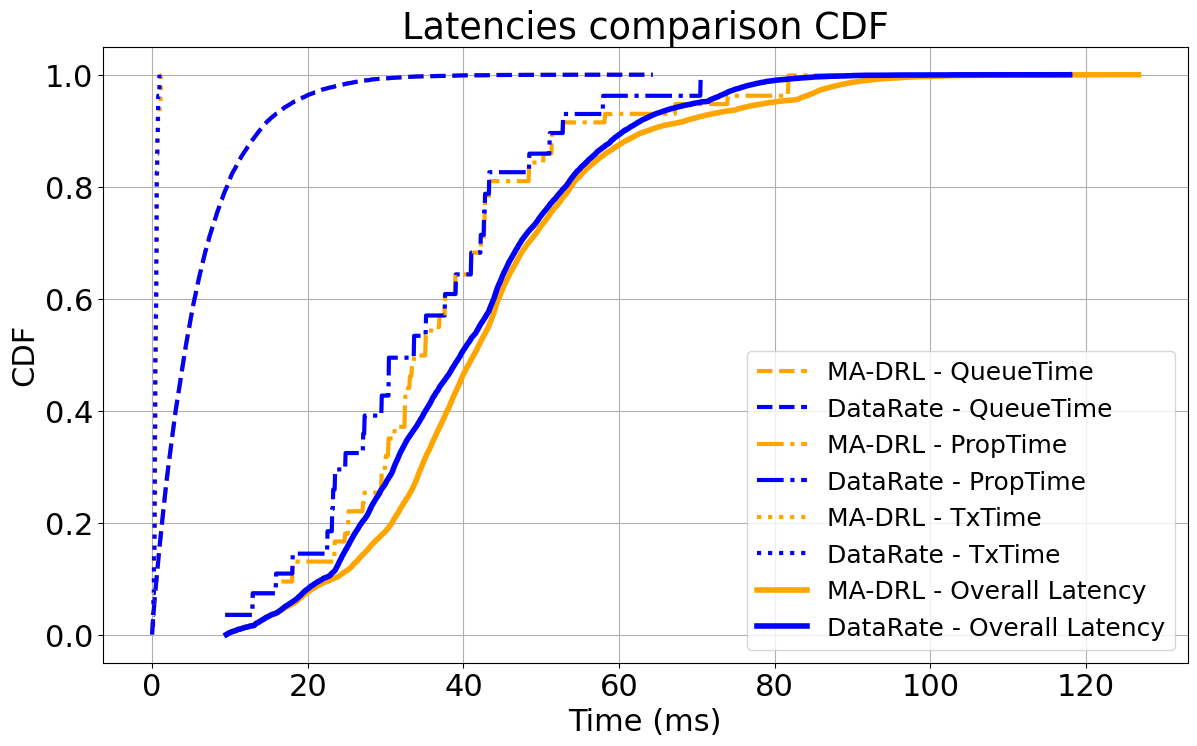

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def save_latency_comparison_plot(drl_path, data_rate_path, output_path):
    # Read the data
    drl_data = pd.read_csv(drl_path)
    data_rate_data = pd.read_csv(data_rate_path)

    # Convert seconds to milliseconds by multiplying the relevant columns by 1000
    components = ['QueueTime', 'PropTime', 'TxTime', 'Latency']
    for component in components:
        drl_data[component] *= 1000
        data_rate_data[component] *= 1000
    
    # Calculate CDFs for queue time, propagation time, Tx time, and overall latency
    components = ['QueueTime', 'PropTime', 'TxTime', 'Latency']
    line_styles = {'QueueTime': '--', 'PropTime': '-.', 'TxTime': ':', 'Latency': '-'}
    colors = {'MA-DRL': 'orange', 'DataRate': 'blue'}
    
    plt.figure(figsize=(14, 8))
    plt.rcParams.update({'font.size': 22, 'legend.fontsize': 18})
    
    for component in components:
        for method, color in colors.items():
            data = drl_data if method == 'MA-DRL' else data_rate_data
            values, base = np.histogram(data[component], bins=1000, density=True)
            cdf = np.cumsum(values) * np.diff(base)
            label = f'{method} - {component}' if component != 'Latency' else f'{method} - Overall Latency'
            plt.plot(base[:-1], cdf, label=label, color=color, linestyle=line_styles[component], linewidth=4 if component == 'Latency' else 3)
    
    # Setting up the plot labels and title
    plt.xlabel('Time (ms)')
    plt.ylabel('CDF')
    plt.title('Latencies comparison CDF')
    plt.legend()
    plt.grid(True)
    
    # Saving the plot
    plt.show()
    # plt.savefig(output_path + 'No_congestion_CDF.png')
    plt.close()

# Example usage
save_latency_comparison_plot('./allLatencies_8_gateways_offline.csv', './allLatencies_8_gateways_DatARate.csv', './')
